<a href="https://www.kaggle.com/code/quanghieulee/unet-model?scriptVersionId=151115742" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install torchsummary
!pip install torchgeometry

from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose, InterpolationMode, CenterCrop
from collections import OrderedDict
from PIL import ImageFilter
import random
import wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.7 MB/s eta 0:00:00


In [2]:
# import tensorflow as tf
# from tensorflow.compat.v1 import InteractiveSession

# # Clear any logs from previous runs
# tf.keras.backend.clear_session()
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
!nvidia-smi -L

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6c1c4050-a214-44d7-a040-a7de791151e8)


device(type='cuda')

In [4]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
num_classes = 3

# Number of epoch
epochs = 15

# Hyperparameters for training 
learning_rate = 2e-04
batch_size = 4
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/unet-checkpoint/unet_model.pth"
# Initialize lists to keep track of loss and accuracy
loss_epoch_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

In [5]:
transform = Compose([CenterCrop(1024),
                     Resize((512, 512), interpolation=InterpolationMode.BILINEAR),
                     PILToTensor()])

In [6]:
class UNetDataClass(Dataset):
    def __init__(self, images_path, masks_path, transform, blur_radius=2, rotation_angle = 180):
        super(UNetDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        masks_list = os.listdir(masks_path)
        
        images_list = [images_path + image_name for image_name in images_list]
        masks_list = [masks_path + mask_name for mask_name in masks_list]
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        self.blur_radius = blur_radius
        self.rotation_angle = rotation_angle
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        # Open image and mask
        data = Image.open(img_path)
        label = Image.open(mask_path)
        
        #Additional Gaussian blur
        data = data.filter(ImageFilter.GaussianBlur(self.blur_radius))
        
        # Additional Random Rotation
        if self.rotation_angle > 0:
            random_angle = random.uniform(-self.rotation_angle, self.rotation_angle)
            data = data.rotate(random_angle)
            label = label.rotate(random_angle)
        
        # Normalize
        data = self.transform(data) / 255
        label = self.transform(label) / 255
        
        label = torch.where(label>0.65, 1.0, 0.0)
        
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return data, label
    
    def __len__(self):
        return len(self.images_list)


In [7]:
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"

unet_dataset = UNetDataClass(images_path, masks_path, transform)

train_size = 0.8
valid_size = 0.2

train_set, valid_set = random_split(unet_dataset, 
                                    [int(train_size * len(unet_dataset)) , 
                                     int(valid_size * len(unet_dataset))])

In [8]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [9]:
class inception_block_same(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(inception_block_same, self).__init__()
        #[inp]->[conv 5x5]->[out]
        self.conv5_1 = nn.Conv2d(in_channels, out_channels//16, kernel_size=1, stride=1, padding='same')
        self.conv5 = nn.Conv2d(out_channels//16, out_channels//4, kernel_size=5, stride=1, padding='same')
        #[inp]->[conv 3x3]->[out]
        self.conv3_1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1, padding='same')
        self.conv3 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=1, padding='same')
        #[inp]->([conv 3x1]+[conv 1x3])->[conv 3x3]->[out]
        self.conv33_1 = nn.Conv2d(in_channels, out_channels//8, kernel_size=1, stride=1, padding='same')
        self.conv33_h = nn.Conv2d(out_channels//8, out_channels//4, kernel_size=(3,1), stride=1, padding='same')
        self.conv33_v = nn.Conv2d(out_channels//8, out_channels//4, kernel_size=(1,3), stride=1, padding='same')
        self.conv33_c = nn.Conv2d(out_channels//2, out_channels//4, kernel_size=(3,3), stride=1, padding='same')
        #[inp]->[maxpool]->[out]
        self.pool_1 = nn.Conv2d(in_channels, out_channels//8, kernel_size=1, stride=1, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=(3,3), stride=1, padding = 1)
        #[inp]->[out]
        self.conv1_1 = nn.Conv2d(in_channels, out_channels//8, kernel_size=1, stride=1, padding='same')
        self.ReLU = nn.ReLU()
        
        
    def forward(self, x):
        #[inp]->[conv 5x5]->[out]        
        l1 = self.conv5_1(x)
        l1 = self.conv5(l1)
        l1 = self.ReLU(l1)
        #[inp]->[conv 3x3]->[out]
        l2 = self.conv3_1(x)
        l2 = self.conv3(l2)
        l2 = self.ReLU(l2)
        #[inp]->([conv 3x1]+[conv 1x3])->[conv 3x3]->[out]
        l3 = self.conv33_1(x)
        
        l31 = self.conv33_h(l3)
        l31 = self.ReLU(l31)
        l32 = self.conv33_v(l3)
        l32 = self.ReLU(l32)
        
        l3 = torch.cat([l31,l32],axis=1)
        l3 = self.conv33_c(l3)
        l3 = self.ReLU(l3)
        #[inp]->[maxpool]->[out]
        l4 = self.pool_1(x)
        l4 = self.ReLU(l4)
        l4 = self.pool(l4)
        #[inp]->[out]
        l5 = self.conv1_1(x)
        l5 = self.ReLU(l5)
        out = torch.cat([l1,l2,l3,l4,l5],axis=1)
        return out

In [10]:
#TeSt = inception_block_same(3, 16)
#summary(TeSt, (64,512,512))

In [11]:
class inception_block_down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(inception_block_down, self).__init__()
        #[inp]->[conv 5x5]->[out]
        self.conv5_1 = nn.Conv2d(in_channels, out_channels//16, kernel_size=1, stride=1, padding='same')
        self.conv5 = nn.Conv2d(out_channels//16, out_channels//4, kernel_size=5, stride=2, padding=2)
        #[inp]->[conv 3x3]->[out]
        self.conv3_1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1, padding='same')
        self.conv3 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2, padding=1)
        #[inp]->([conv 3x1]+[conv 1x3])->[conv 3x3]->[out]
        self.conv33_1 = nn.Conv2d(in_channels, out_channels//8, kernel_size=1, stride=1, padding='same')
        self.conv33_h = nn.Conv2d(out_channels//8, out_channels//4, kernel_size=(3,1), stride=1, padding='same')
        self.conv33_v = nn.Conv2d(out_channels//8, out_channels//4, kernel_size=(1,3), stride=1, padding='same')
        self.conv33_c = nn.Conv2d(out_channels//2, out_channels//4, kernel_size=(3,3), stride=2, padding=1)
        #[inp]->[maxpool]->[out]
        self.pool_1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        
        self.ReLU = nn.ReLU()
        
        
    def forward(self, x):
        #[inp]->[conv 5x5]->[out]
        l1 = self.conv5_1(x)
        l1 = self.conv5(l1)
        l1 = self.ReLU(l1)
        #[inp]->[conv 3x3]->[out]
        l2 = self.conv3_1(x)
        l2 = self.conv3(l2)
        l2 = self.ReLU(l2)
        #[inp]->([conv 3x1]+[conv 1x3])->[conv 3x3]->[out]
        l3 = self.conv33_1(x)
        
        l31 = self.conv33_h(l3)
        l31 = self.ReLU(l31)
        l32 = self.conv33_v(l3)
        l32 = self.ReLU(l32)
        
        l3 = torch.cat([l31,l32],axis=1)
        l3 = self.conv33_c(l3)
        l3 = self.ReLU(l3)
        #[inp]->[maxpool]->[out]
        l4 = self.pool_1(x)
        l4 = self.ReLU(l4)
        l4, indices = self.pool(l4)
        
        out = torch.cat([l1,l2,l3,l4],axis=1)
        return out, indices

In [12]:
class inception_block_up(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super(inception_block_up, self).__init__()
        #[inp]->[transposeconv 5x5]->[out]
        self.conv5_1 = nn.Conv2d(in_channels, out_channels//16, kernel_size=(1,1), stride=1, padding='same')
        self.conv5 = nn.ConvTranspose2d(out_channels//16, out_channels//4, kernel_size=(5,5), stride=2, padding=2, output_padding=1)
        #[inp]->[transposeconv 2x2]->[out]
        self.conv2_1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=(1,1), stride=1, padding='same')
        self.conv2 = nn.ConvTranspose2d(out_channels//4, out_channels//2, kernel_size=(2,2), stride=2)
        #[inp]->[unmaxpool 2x2]->[out]
        self.pool_1 = nn.Conv2d(in_channels, skip_channels//4, kernel_size=(1,1), stride=1, padding='same')
        self.pool = nn.MaxUnpool2d(kernel_size=(2,2), stride=2)
        self.pool_a = nn.Conv2d(skip_channels//4, out_channels//4, kernel_size=1, stride=1, padding='same')
        
        self.ReLU = nn.ReLU()
        
        
    def forward(self, x, indices):
        #[inp]->[transposeconv 5x5]->[out]
        l1 = self.conv5_1(x)
        l1 = self.conv5(l1)
        l1 = self.ReLU(l1)
        #[inp]->[transposeconv 2x2]->[out]
        l2 = self.conv2_1(x)
        l2 = self.conv2(l2)
        l2 = self.ReLU(l2)
        #[inp]->[unmaxpool 2x2]->[out]        
        l3 = self.pool_1(x)
        l3 = self.ReLU(l3)
        l3 = self.pool(l3, indices)
        l3 = self.pool_a(l3)
        l3 = self.ReLU(l3)
        
        out = torch.cat([l1,l2,l3],axis=1)
        return out

In [13]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder, self).__init__()
        self.same = inception_block_same(in_channels, out_channels)
        self.down = inception_block_down(out_channels, out_channels)
    def forward(self, x):
        skip = self.same(x)
        out, indices = self.down(skip)
        return out, skip, indices
        
        
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels):
        super(decoder, self).__init__()
        self.up = inception_block_up(in_channels, out_channels, skip_channels)
        self.same = inception_block_same(out_channels+skip_channels, out_channels)
    def forward(self, x, skip, indices):
        x = self.up(x, indices)
        catted = torch.cat([x, skip], axis=1)
        out = self.same(catted)
        return out
        

In [14]:
class UnetModel(nn.Module):
    def __init__(self, n_class=3):
        super(UnetModel, self).__init__()
        #5 encoder:
        self.enc1 = encoder(3,16)
        self.enc2 = encoder(16,32)
        self.enc3 = encoder(32,64)
        self.enc4 = encoder(64,128)
        self.enc5 = encoder(128,256)
        #2 same block
        self.same1 = inception_block_same(256,512)
        self.same2 = inception_block_same(512,1024)
        #5 decoder
        self.dec5 = decoder(1024,512,256)
        self.dec4 = decoder(512,256,128)
        self.dec3 = decoder(256,128,64)
        self.dec2 = decoder(128,64,32)
        self.dec1 = decoder(64,32,16)
        #conv 1x1
        self.out = nn.Conv2d(32, n_class, kernel_size=1, padding='same')
    
    def forward(self, image):
        o1, s1, i1 = self.enc1(image)
        o2, s2, i2 = self.enc2(o1)
        o3, s3, i3 = self.enc3(o2)
        o4, s4, i4 = self.enc4(o3)
        o5, s5, i5 = self.enc5(o4)
        
        b1 = self.same1(o5)
        b2 = self.same2(b1)
        
        d5 = self.dec5(b2, s5, i5)
        d4 = self.dec4(d5, s4, i4)
        d3 = self.dec3(d4, s3, i3)
        d2 = self.dec2(d3, s2, i2)
        d1 = self.dec1(d2, s1, i1)
        
        ret = self.out(d1)
        
        return ret
        

class encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(encoder_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        next_layer = self.max_pool(x)
        skip_layer = x
        
        return next_layer, skip_layer

class decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(decoder_block, self).__init__()
        
        self.transpose_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x, skip_layer):
        x = self.transpose_conv(x)
        x = torch.cat([x, skip_layer], axis=1)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

class bottleneck_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(bottleneck_block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

# UNet model
class UNet(nn.Module):
    def __init__(self, n_class=3):
        super(UNet, self).__init__()
        # Encoder blocks
        self.enc1 = encoder_block(3, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        
        # Bottleneck block
        self.bottleneck = bottleneck_block(512, 1024)
        
        # Decoder blocks
        self.dec1 = decoder_block(1024, 512)
        self.dec2 = decoder_block(512, 256)
        self.dec3 = decoder_block(256, 128)
        self.dec4 = decoder_block(128, 64)
        
        # 1x1 convolution
        self.out = nn.Conv2d(64, n_class, kernel_size=1, padding='same')
        
    def forward(self, image):
        n1, s1 = self.enc1(image)
        n2, s2 = self.enc2(n1)
        n3, s3 = self.enc3(n2)
        n4, s4 = self.enc4(n3)
        
        n5 = self.bottleneck(n4)
        
        n6 = self.dec1(n5, s4)
        n7 = self.dec2(n6, s3)
        n8 = self.dec3(n7, s2)
        n9 = self.dec4(n8, s1)
        
        output = self.out(n9)
        
        return output

In [15]:
class CEDiceLoss(nn.Module):
    def __init__(self, weights) -> None:
        super(CEDiceLoss, self).__init__()
        self.eps: float = 1e-6
        self.weights: torch.Tensor = weights

    def forward(
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(input):
            raise TypeError("Input type is not a torch.Tensor. Got {}"
                            .format(type(input)))
        if not len(input.shape) == 4:
            raise ValueError("Invalid input shape, we expect BxNxHxW. Got: {}"
                             .format(input.shape))
        if not input.shape[-2:] == target.shape[-2:]:
            raise ValueError("input and target shapes must be the same. Got: {}"
                             .format(input.shape, input.shape))
        if not input.device == target.device:
            raise ValueError(
                "input and target must be in the same device. Got: {}" .format(
                    input.device, target.device))
        if not self.weights.shape[1] == input.shape[1]:
            raise ValueError("The number of weights must equal the number of classes")
        if not torch.sum(self.weights).item() == 1:
            raise ValueError("The sum of all weights must equal 1")
            
        # cross entropy loss
        celoss = nn.CrossEntropyLoss(self.weights)(input, target)
        
        # compute softmax over the classes axis
        input_soft = F.softmax(input, dim=1)

        # create the labels one hot tensor
        target_one_hot = one_hot(target, num_classes=input.shape[1],
                                 device=input.device, dtype=input.dtype)

        # compute the actual dice score
        dims = (2, 3)
        intersection = torch.sum(input_soft * target_one_hot, dims)
        cardinality = torch.sum(input_soft + target_one_hot, dims)

        dice_score = 2. * intersection / (cardinality + self.eps)
        
        dice_score = torch.sum(dice_score * self.weights, dim=1)
        
        return torch.mean(1. - dice_score) + celoss


In [16]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [17]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader,learing_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learing_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target)
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= (i+1)
    
    return train_loss_epoch , test_loss_epoch

In [18]:
# Test function
def test(dataloader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, targets) in enumerate(dataloader):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, pred = torch.max(outputs, 1)
            test_loss += targets.size(0)
            correct += torch.sum(pred == targets).item()
    return 100.0 * correct / test_loss

In [19]:
model = UnetModel()
model.apply(weights_init)
# model = nn.DataParallel(model)
#checkpoint = torch.load(pretrained_path)

#new_state_dict = OrderedDict()
#for k, v in checkpoint['model'].items():
#    name = k[7:] # remove `module.`
#    new_state_dict[name] = v
# load params
#model.load_state_dict(new_state_dict)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): UnetModel(
    (enc1): encoder(
      (same): inception_block_same(
        (conv5_1): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (conv5): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=same)
        (conv3_1): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (conv3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (conv33_1): Conv2d(3, 2, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (conv33_h): Conv2d(2, 4, kernel_size=(3, 1), stride=(1, 1), padding=same)
        (conv33_v): Conv2d(2, 4, kernel_size=(1, 3), stride=(1, 1), padding=same)
        (conv33_c): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (pool_1): Conv2d(3, 2, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (pool): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
        (conv1_1): Conv2d(3, 2, kernel_size=(1, 1), stride=(1, 1), padding=same)
 

In [20]:
weights = torch.Tensor([[0.4, 0.55, 0.05]]).cuda()
loss_function = CEDiceLoss(weights)

In [21]:
# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
#optimizer.load_state_dict(checkpoint['optimizer'])

# Learning rate scheduler
learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.6)

In [22]:
save_model(model, optimizer, checkpoint_path)

In [23]:
wandb.login(
    # set the wandb project where this run will be logged
#     project= "PolypSegment", 
    key = "58347058cb54d574bc86f5bfd5f80134db7ec5cd",
)
wandb.init(
    project = "bkao-neopolyp"
)
# Training loop
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})
#     train_accuracy.append(test(train_loader))
#     valid_accuracy.append(test(test_loader))
#     print("Epoch {}: loss: {:.4f}, train accuracy: {:.4f}, valid accuracy:{:.4f}".format(epoch + 1, 
#                                         train_loss_array[-1], train_accuracy[-1], valid_accuracy[-1]))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lichtut (lichtut0). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231117_104245-i8l6pe7d
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run whole-deluge-49
wandb: ⭐️ View project at https://wandb.ai/lichtut0/bkao-neopolyp
wandb: 🚀 View run at https://wandb.ai/lichtut0/bkao-neopolyp/runs/i8l6pe7d


Start epoch #1, learning rate for this epoch: [0.0002]
Train Epoch: 1 [200/800 (25.0%)]	Loss: 1.9256
Train Epoch: 1 [400/800 (50.0%)]	Loss: 1.9135
Train Epoch: 1 [600/800 (75.0%)]	Loss: 1.8519
Train Epoch: 1 [800/800 (100.0%)]	Loss: 1.9457
Done epoch #1, time for this epoch: 150.16387748718262s
Start epoch #2, learning rate for this epoch: [0.0002]
Train Epoch: 2 [200/800 (25.0%)]	Loss: 1.7339
Train Epoch: 2 [400/800 (50.0%)]	Loss: 1.8369
Train Epoch: 2 [600/800 (75.0%)]	Loss: 1.7317
Train Epoch: 2 [800/800 (100.0%)]	Loss: 1.5621
Done epoch #2, time for this epoch: 133.05960822105408s
Start epoch #3, learning rate for this epoch: [0.0002]
Train Epoch: 3 [200/800 (25.0%)]	Loss: 1.6744
Train Epoch: 3 [400/800 (50.0%)]	Loss: 1.5325
Train Epoch: 3 [600/800 (75.0%)]	Loss: 1.6903
Train Epoch: 3 [800/800 (100.0%)]	Loss: 1.6210
Done epoch #3, time for this epoch: 136.31885409355164s
Start epoch #4, learning rate for this epoch: [0.0002]
Train Epoch: 4 [200/800 (25.0%)]	Loss: 1.4940
Train Epoch

In [24]:
torch.cuda.empty_cache()

In [25]:
# load_model(model, checkpoint)

plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 4)
epochs_array = range(epochs)

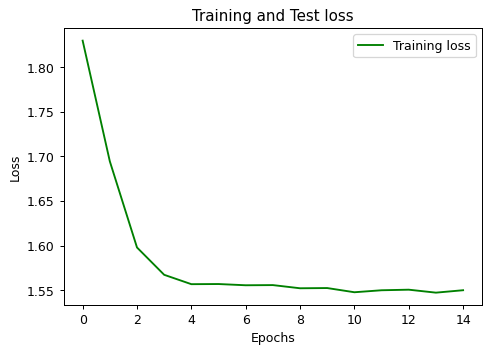

In [26]:
# Plot Training and Test loss
plt.plot(epochs_array, train_loss_array, 'g', label='Training loss')
# plt.plot(epochs_array, test_loss_array, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# from torch.jit import load
# model = UNet()
# optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# checkpoint = torch.load(pretrained_path)

# optimizer.load_state_dict(checkpoint['optimizer'])

# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint['model'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)

In [27]:
for i, (data, label) in enumerate(train_dataloader):
    img = data
    mask = label
    break

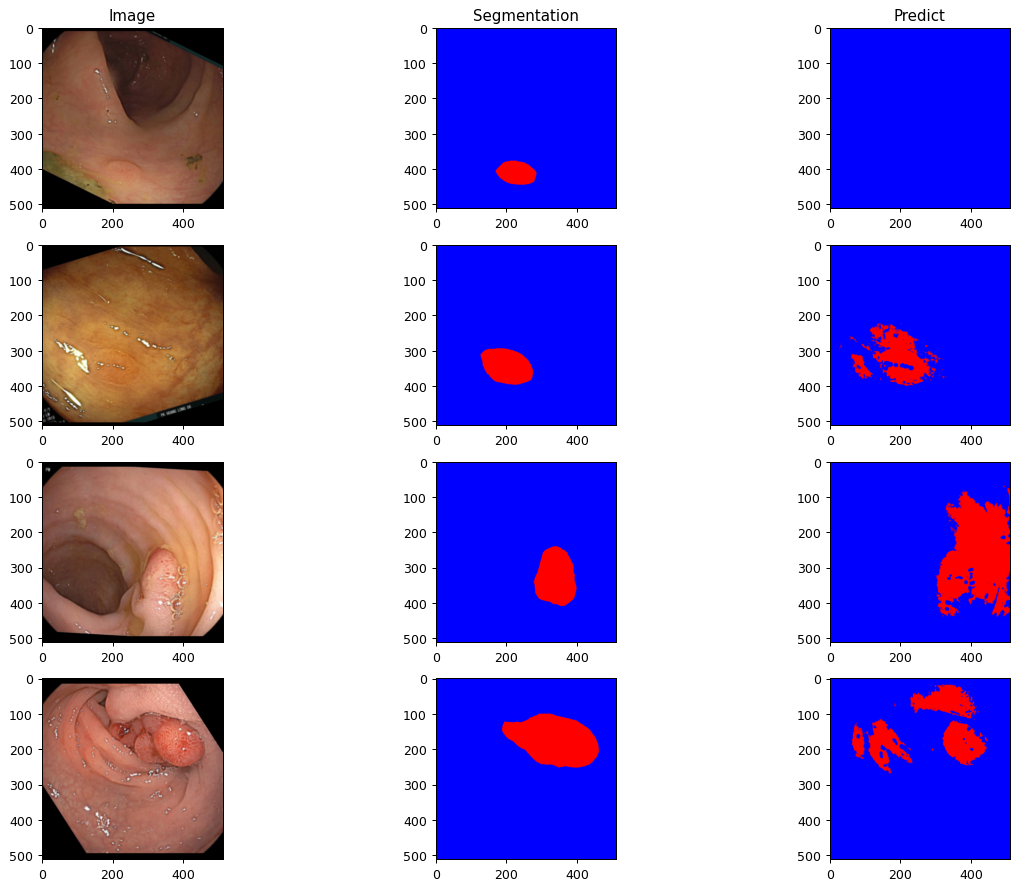

In [28]:
fig, arr = plt.subplots(4, 3, figsize=(16, 12))
arr[0][0].set_title('Image')
arr[0][1].set_title('Segmentation')
arr[0][2].set_title('Predict')

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(4):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    
    arr[i][1].imshow(F.one_hot(mask[i]).float())
    
    arr[i][2].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

In [29]:
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data) / 255        
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

In [30]:
path = '/kaggle/input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=True)


In [31]:
for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break

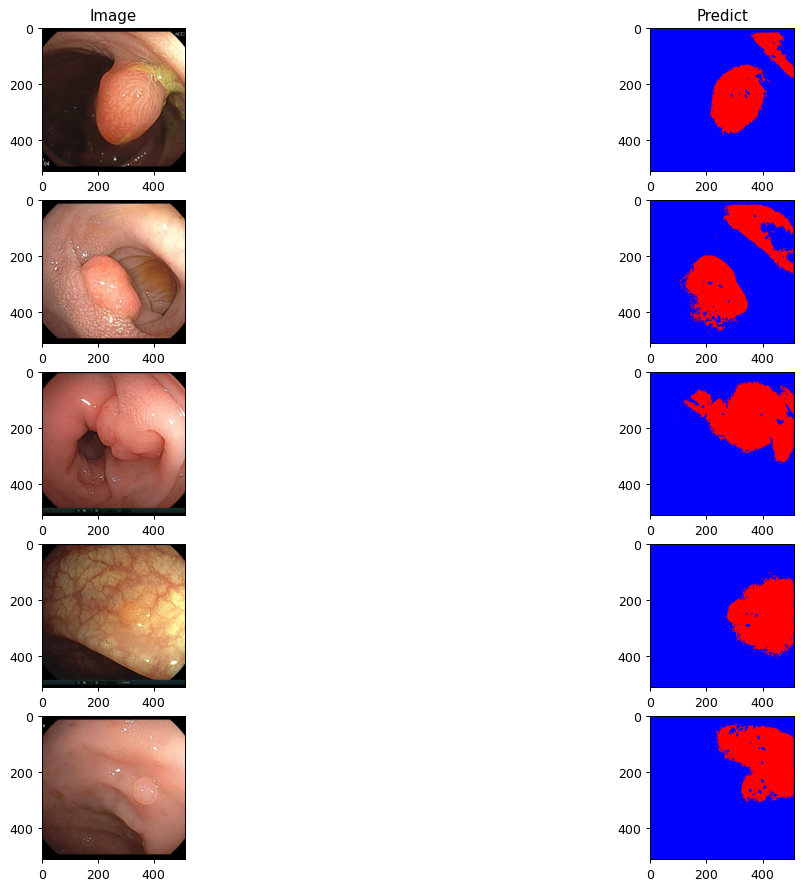

In [32]:
fig, arr = plt.subplots(5, 2, figsize=(16, 12))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(5):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

In [33]:
model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        
        mask2img = (ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        
        mask2img = Resize((1024,1024), interpolation=InterpolationMode.NEAREST)(mask2img)
        mask2img = CenterCrop((h[i].item(), w[i].item()))(mask2img)
        
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))

In [34]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output.csv', index=False)

/kaggle/working/predicted_masks/6ddca6ee1af35b65bd9ea42cfcfedb5e.png
/kaggle/working/predicted_masks/05b78a91391adc0bb223c4eaf3372eae.png
/kaggle/working/predicted_masks/2d9e593b6be1ac29adbe86f03d900fd1.png
/kaggle/working/predicted_masks/a6e51d077bad31c8c5f54ffaa27a6235.png
/kaggle/working/predicted_masks/e73749a0d21db70dd094a7f32574d6c7.png
/kaggle/working/predicted_masks/6b83ef461c2a337948a41964c1d4f50a.png
/kaggle/working/predicted_masks/b21960c94b0aab4c024a573c692195f8.png
/kaggle/working/predicted_masks/5beb48f0be11d0309d1dff09b8405734.png
/kaggle/working/predicted_masks/391adc0bb223c4eaf3372eae567c94ea.png
/kaggle/working/predicted_masks/4e8bfb905b78a91391adc0bb223c4eaf.png
/kaggle/working/predicted_masks/d6240619ebebe9e9c9d00a4262b4fe4a.png
/kaggle/working/predicted_masks/f8e26031fbb5e52c41545ba55aadaa77.png
/kaggle/working/predicted_masks/395e56a6d9ba9d45c3dbc695325ded46.png
/kaggle/working/predicted_masks/71f2fd85a04faeeb2b535797395305af.png
/kaggle/working/predicted_masks/3c